Test -> Was ist der Unterschied zwischen den Centroid Matching Methoden?
1. OSM zu Centroid mit ALKIS Polygonen matchen -> 2054 Matches und 72 Duplikate
2. ALKIS zu Centroid mit OSM Polygonen matchen -> 3039 Matchen und 2 Duplikate

-> Verifizierung der Dopplungen steht aus (was wurde wie gematcht, wie werden die Duplikate identifiziert?)

In [4]:
from lxml import etree

# Lade die CityGML-Datei
import os
current_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
file_path = os.path.join(current_dir, 'data', 'raw', 'Bayern', '696_5346.gml')
tree = etree.parse(file_path)

# Root of xml tree
root = tree.getroot()

# Quick exploration of the tree structure
# explore tree
#for elem in root.iter():
#    print(f"{elem.tag}: {elem.text}")

In [5]:
# Suche nach dem gml:Envelope Element
from pyproj import CRS
# Define the namespaces used in the CityGML file
ns = {
        'core': "http://www.opengis.net/citygml/2.0",
        'gml': "http://www.opengis.net/gml",
        'bldg' : 'http://www.opengis.net/citygml/building/2.0',
        'energy' : 'http://www.sig3d.org/citygml/2.0/energy/1.0',
        # Add other necessary namespaces based on the file content
    }
envelope = root.find('.//gml:Envelope', namespaces=ns)
 
# Extrahiere das srsName Attribut
if envelope is not None:
    srs_name = envelope.get('srsName')
    print(f"Koordinatensystem (srsName): {srs_name}")
    srsName = "EPSG:25832"
    crs = CRS.from_string(srsName)
    print(crs)
else:
    print("gml:Envelope Element nicht gefunden.")


Koordinatensystem (srsName): urn:adv:crs:ETRS89_UTM32*DE_DHHN2016_NH
EPSG:25832


In [7]:
import pandas as pd
import os
import lxml.etree as ET


# Find all buildings and get the data
for building in root.findall('.//{*}Building'):
    # Get all IDs and yoc
    building_id = building.get('{http://www.opengis.net/gml}id')

print(building_id)

DEBY_LOD2_5239204


In [9]:
# Map GML ID to CEA ID 
from lxml import etree
import shapely.geometry as geom
import matplotlib.pyplot as plt
import geopandas as gpd


# Code taken from https://github.com/TUB-DVG/TECDEM/blob/main/experiments/92a_ModelUpdatedGML.ipynb 

# Extract building geometries along with their IDs

def extract_ground_surface_polygons_with_ids(gml_root):
    buildings = []

    # Iterate over each building
    for bldg in gml_root.findall('.//{*}Building', ns):
        bldg_id = bldg.get('{http://www.opengis.net/gml}id')
        #print(bldg)

        # Find all GroundSurface elements within the boundedBy elements
        for ground_surface in bldg.findall('.//{*}GroundSurface', ns):
            pos_list_elements = ground_surface.findall('.//gml:posList', ns)
            if pos_list_elements is not None:
                for geom_elem in pos_list_elements:
                    pos_list = geom_elem.text.split()
                    if len(pos_list) % 3 != 0:
                        print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                        continue
                    try:
                        # Convert coordinates to a 2D polygon (ignoring z-values)
                        exterior_coords = []
                        interior_coords = []
                        
                        # Find exterior coordinates
                        exterior = ground_surface.find('.//gml:exterior//gml:posList', ns)
                        if exterior is not None:
                            exterior_pos_list = exterior.text.split()
                            exterior_coords = [(float(exterior_pos_list[i]), float(exterior_pos_list[i + 1])) for i in range(0, len(exterior_pos_list), 3)]
                        
                        # Find interior coordinates
                        interiors = ground_surface.findall('.//gml:interior//gml:posList', ns)
                        for interior in interiors:
                            interior_pos_list = interior.text.split()
                            interior_coords.append([(float(interior_pos_list[i]), float(interior_pos_list[i + 1])) for i in range(0, len(interior_pos_list), 3)])
                        
                        # Create polygon with exterior and interior (holes)
                        polygon = geom.Polygon(exterior_coords, interior_coords)
                        buildings.append({'geometry': polygon, 'gml_id': bldg_id})
                    except Exception as e:
                        print(f"Error creating polygon for building {bldg_id}: {e}")
            else:
                # Alternatively, check for 'Polygon' elements under GroundSurface
                for poly in ground_surface.findall('.//gml:Polygon', ns):
                    exterior_coords = []
                    interior_coords = []
                    
                    # Find exterior coordinates
                    exterior = poly.find('.//gml:exterior//gml:posList', ns)
                    if exterior is not None:
                        exterior_pos_list = exterior.text.split()
                        if len(exterior_pos_list) % 3 != 0:
                            print(f"Warning: exterior posList does not contain triplets of coordinates: {exterior_pos_list}")
                            continue
                        exterior_coords = [(float(exterior_pos_list[i]), float(exterior_pos_list[i + 1])) for i in range(0, len(exterior_pos_list), 3)]
                    
                    # Find interior coordinates
                    interiors = poly.findall('.//gml:interior//gml:posList', ns)
                    for interior in interiors:
                        interior_pos_list = interior.text.split()
                        if len(interior_pos_list) % 3 != 0:
                            print(f"Warning: interior posList does not contain triplets of coordinates: {interior_pos_list}")
                            continue
                        interior_coords.append([(float(interior_pos_list[i]), float(interior_pos_list[i + 1])) for i in range(0, len(interior_pos_list), 3)])
                    
                    try:
                        # Create polygon with exterior and interior (holes)
                        polygon = geom.Polygon(exterior_coords, interior_coords)
                        buildings.append({'geometry': polygon, 'gml_id': bldg_id})
                    except Exception as e:
                        print(f"Error creating polygon for building {bldg_id}: {e}")

    return buildings



# Now, update the code to use the modified function
list_buildings = []
root = tree.getroot()
# Use the modified function that extracts only ground surfaces
print(root)
buildings = extract_ground_surface_polygons_with_ids(root)
list_buildings.extend(buildings)  # Use extend to flatten the list



<Element {http://www.opengis.net/citygml/1.0}CityModel at 0x2055c7b4cc0>


In [10]:

import osmnx as ox
import geopandas as gpd

place_name = "Garching b. München"
area = ox.geocode_to_gdf(place_name)

tags = {'building': True}   

buildings_osm = ox.features_from_place(place_name, tags)
buildings_osm.head()

geometry  \
element  id                                                              
node     2246425108                          POINT (11.63661 48.24966)   
         5763636116                           POINT (11.63361 48.2494)   
         9348944907                          POINT (11.67796 48.26679)   
relation 36276       POLYGON ((11.67363 48.26535, 11.67353 48.26496...   
         49613       POLYGON ((11.67066 48.26841, 11.67083 48.26839...   

                    addr:housenumber             addr:street    building  \
element  id                                                                
node     2246425108               65    Schleißheimer Straße         yes   
         5763636116               37                Parkring  university   
         9348944907              NaN                     NaN         yes   
relation 36276                     1  Walther-Meißner-Straße  university   
         49613                     4       Lichtenbergstraße  university   

                                               name   office  \
element  id                                                    
node     2246425108        Elektro Schattenkirchner  company   
         5763636116  Technische Universität München      NaN   
         9348944907                             NaN      NaN   
relation 36276                                  NaN      NaN   
         49613                TUM Department Chemie      NaN   

                        opening_hours     location             addr:city  \
element  id                                                                
node     2246425108               NaN          NaN                   NaN   
         5763636116  Mo-Fr 8:00-17:00          NaN                   NaN   
         9348944907               NaN  underground                   NaN   
relation 36276                    NaN          NaN  Garching bei München   
         49613                    NaN          NaN  Garching bei München   

                    addr:country  ... construction climbing          type  \
element  id                       ...                                       
node     2246425108          NaN  ...          NaN      NaN           NaN   
         5763636116          NaN  ...          NaN      NaN           NaN   
         9348944907          NaN  ...          NaN      NaN           NaN   
relation 36276               NaN  ...          NaN      NaN  multipolygon   
         49613                DE  ...          NaN      NaN  multipolygon   

                    temporary wheelchair:description college operator:type  \
element  id                                                                  
node     2246425108       NaN                    NaN     NaN           NaN   
         5763636116       NaN                    NaN     NaN           NaN   
         9348944907       NaN                    NaN     NaN           NaN   
relation 36276            NaN                    NaN     NaN           NaN   
         49613            NaN                    NaN     NaN           NaN   

                    area building:flats house  
element  id                                    
node     2246425108  NaN            NaN   NaN  
         5763636116  NaN            NaN   NaN  
         9348944907  NaN            NaN   NaN  
relation 36276       NaN            NaN   NaN  
         49613       NaN            NaN   NaN  

[5 rows x 189 columns]

2054
3923
4084


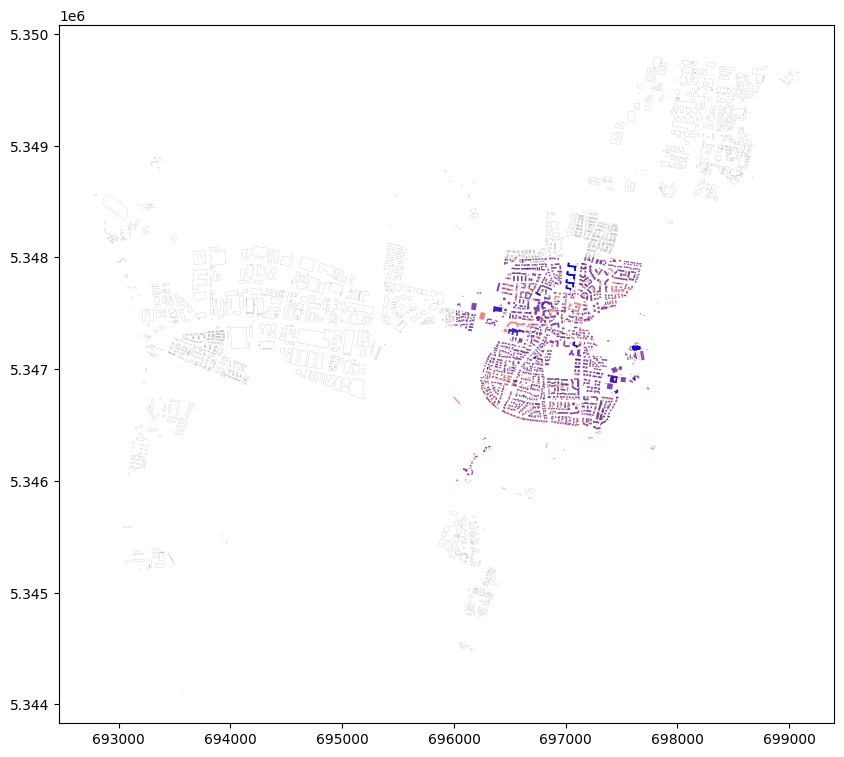

In [11]:
# Check if we have extracted any buildings
if not list_buildings:
    print("No buildings were extracted from the GML files.")
else:
    # Convert to GeoDataFrame
    
    buildings_gdf = gpd.GeoDataFrame(list_buildings, crs='EPSG:25832')
    # buildings_gdf = buildings_gdf.to_crs('EPSG:4326')
    # Select columns using a list instead of a tuple
    columns_to_keep = ['amenity', 'wheelchair','geometry']
    blocks_gdf = buildings_osm[columns_to_keep]
    blocks_gdf = blocks_gdf.to_crs('EPSG:25832')
    # Check if buildings are within blocks
    buildings_gdf = buildings_gdf.reset_index(drop=True)
    buildings_osm = blocks_gdf.reset_index(drop=True)
    buildings_osm_centroids = buildings_osm.copy()
    buildings_osm_centroids["geometry"] = buildings_osm["geometry"].centroid
    # within_blocks = gpd.sjoin_nearest(buildings_gdf, blocks_gdf, how='inner', max_distance=1, distance_col = "distances")
    within_blocks = gpd.sjoin(buildings_gdf, buildings_osm_centroids, how='inner', predicate="intersects") # plottet die geometrie von erstem gdf
    print(len(within_blocks))
    print(len(buildings_gdf))
    print(len(buildings_osm))

    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=0.05, edgecolor='black')
    buildings_gdf.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    plt.show()

In [12]:
without_duplicates = within_blocks["gml_id"].drop_duplicates()

difference = len(within_blocks) - len(without_duplicates)

difference

72

3039
3923
4084


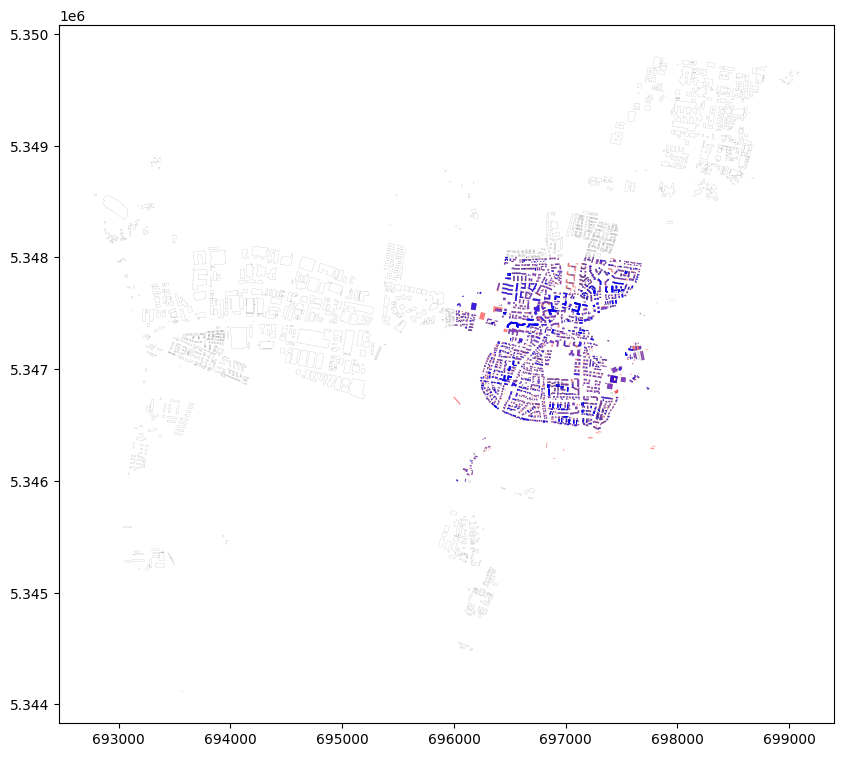

In [13]:
# Check if we have extracted any buildings
if not list_buildings:
    print("No buildings were extracted from the GML files.")
else:
    # Convert to GeoDataFrame
    
    buildings_gdf = gpd.GeoDataFrame(list_buildings, crs='EPSG:25832')
    # buildings_gdf = buildings_gdf.to_crs('EPSG:4326')
    # Select columns using a list instead of a tuple
    columns_to_keep = ['amenity', 'wheelchair','geometry']
    blocks_gdf = buildings_osm[columns_to_keep]
    blocks_gdf = blocks_gdf.to_crs('EPSG:25832')
    # Check if buildings are within blocks
    buildings_gdf = buildings_gdf.reset_index(drop=True)
    buildings_osm = blocks_gdf.reset_index(drop=True)
    buildings_gdf_centroids = buildings_gdf.copy()
    buildings_gdf_centroids["geometry"] = buildings_gdf["geometry"].centroid
    # within_blocks = gpd.sjoin_nearest(buildings_gdf, blocks_gdf, how='inner', max_distance=1, distance_col = "distances")
    within_blocks = gpd.sjoin(blocks_gdf, buildings_gdf_centroids, how='inner', predicate="intersects") # plottet die geometrie von erstem gdf
    print(len(within_blocks))
    print(len(buildings_gdf))
    print(len(buildings_osm))

    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=0.05, edgecolor='black')
    buildings_gdf.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    plt.show()

In [14]:
within_blocks.head()

,amenity,wheelchair,geometry,index_right,gml_id
19,NaN,NaN,"POLYGON ((697465.005 5346935.951, 697455.476 5...",1847,DEBY_LOD2_43772342
19,NaN,NaN,"POLYGON ((697465.005 5346935.951, 697455.476 5...",1848,DEBY_LOD2_43772342
89,NaN,NaN,"POLYGON ((697084.208 5346663.117, 697105.811 5...",1590,DEBY_LOD2_5240223
90,NaN,NaN,"POLYGON ((697058.773 5346697.955, 697080.661 5...",1716,DEBY_LOD2_5239985
91,NaN,NaN,"POLYGON ((697157.477 5347118.044, 697180.193 5...",3708,DEBY_LOD2_5239764


In [15]:
without_duplicates = within_blocks["gml_id"].drop_duplicates()

difference = len(within_blocks) - len(without_duplicates)

difference

2

<bldg:address>
<Address><xalAddress><xAL:AddressDetails>
 <xAL:Country>
  <xAL:CountryName>Germany</xAL:CountryName>
  <xAL:Locality Type="Town">
   <xAL:LocalityName>Garching b.München</xAL:LocalityName>
   <xAL:Thoroughfare Type="Street">
    <xAL:ThoroughfareName>Watzmannring 50</xAL:ThoroughfareName>
   </xAL:Thoroughfare>
  </xAL:Locality>
 </xAL:Country>
</xAL:AddressDetails></xalAddress>
</Address>
</bldg:address>


In [16]:
address_df = { 'bldg_id' : [], 'addr:city' : [],
    'addr:housenumber' : [],
    'addr:street' : [],
    'addr:postcode' : [], 
 }

In [17]:
namespaces = {
    'xAL': 'urn:oasis:names:tc:ciq:xal:3',
    'bldg': 'http://www.example.com/building'
}
for building in root.findall('.//{*}Building'):
    # Get all IDs and yoc
    building_id = building.get('{http://www.opengis.net/gml}id')
    address_node = building.find('.//{*}address')
    if address_node:
        street = address_node.find('.//xAL:ThoroughfareName', namespaces).text
        city = address_node.find('.//xAL:LocalityName', namespaces).text
        address_df["addr:city"].append(city)
        address_df["addr:street"].append(street.split(" ")[0])
        address_df["addr:street"].append(street.split(" ")[1])
    address_df["bldg_id"].extend(building_id)

C:\Users\felix\AppData\Local\Temp\ipykernel_16224\376900682.py:9: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if address_node:


AttributeError: 'NoneType' object has no attribute 'text'